<a href="https://colab.research.google.com/github/nagarajuerigi/Learning/blob/master/Copy_of_COVID_19_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Bilogistic Modeling

This file fits a bi-logistic curve to current COVID-19 confirmed cases and plots some projections of what that might look like over time.

This is definitely more of an exploratory analysis than a definitive projection of any kind, and should be taken as such. You've been warned! The "known unknowns" of the model are relatively small (it has good fit estimations), but the "unknown unknowns" (problems in input data like differences in testing, overfitting, whether this model works in general, lots of things I'm probably missing, etc.) are probably quite large. 

Standard imports.

In [0]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats.distributions as dist
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Some styling so it looks decently nice. Change USE_DARK from True to False if your Google Colab setup is light theme.

In [0]:
dark_rc = {
    'axes.spines.top': 'False',
    'axes.spines.right': 'False',
    'xtick.major.size': '7',
    'xtick.minor.size': '2',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.bottom': 'False',
    'ytick.left': 'False',
    'axes.edgecolor': 'grey',
    'figure.facecolor': '0.05',
    'axes.facecolor': '0.05',
    'text.color': '0.98',
    'xtick.color': '0.98',
    'ytick.color': '0.98',
}

light_rc = {
    'axes.spines.top': 'False',
    'axes.spines.right': 'False',
    'xtick.major.size': '7',
    'xtick.minor.size': '2',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.bottom': 'False',
    'ytick.left': 'False',
    'axes.edgecolor': 'grey',
    'figure.facecolor': '0.97',
    'axes.facecolor': '0.97',
    'text.color': '0.05',
    'xtick.color': '0.2',
    'ytick.color': '0.2',
}

USE_DARK = True
if USE_DARK:
    sns.set(context='paper', style='dark', palette='plasma', rc=dark_rc)
else:
    sns.set(context='paper', style='white', palette='plasma', rc=light_rc)

In [0]:
colors = sns.color_palette('plasma', 7)

The actual data. It links to a GitHub URL, so it should be current to when you run it (I think) 

The URL in clickable form: [click me!](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)

There's some data manipulation stuff I do to get it into the format I want: none of it really impacts the modeling so I wouldn't worry about it.

In [0]:
# links to https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
CASES_URL = "https://git.io/JvxHQ"

data = pd.read_csv(CASES_URL)

data = data.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='day', value_name='cases')
data['day'] = pd.to_datetime(data['day'])
data.set_index(['day', 'Country/Region'], inplace=True)
data.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)
data.tail()

cases
day        Country/Region              
2020-04-13 France                     1
           South Sudan                4
           Western Sahara             6
           Sao Tome and Principe      4
           Yemen                      1

I found it easier to just use the total cases. If you wanted to break this up by country, you could: replace `total_cases` with the commented-out lines and replace `'United Kingdom'` with whatever country name you like. You can also do, instead of `==`, `.isin()` to get a list of countries. (There are some weird anomalies: the UK data seems to only be published every week or something, and I'm sure there's a lot more weird issues like that if you dig deeper.)


In [0]:
# links to https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
DEATHS_URL = "https://git.io/JvpP6"
deaths = pd.read_csv(DEATHS_URL)

deaths = deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='day', value_name='deaths')
deaths['day'] = pd.to_datetime(deaths['day'])
deaths.set_index(['day', 'Country/Region'], inplace=True)
deaths.drop(columns=['Province/State', 'Lat', 'Long'], inplace=True)
deaths.tail()

deaths
day        Country/Region               
2020-04-13 France                      0
           South Sudan                 0
           Western Sahara              0
           Sao Tome and Principe       0
           Yemen                       0

In [0]:
total_cases = data.groupby("day").sum()
# total_cases = data.reset_index(1)
# total_cases = total_cases[total_cases['Country/Region'] == 'United Kingdom']
# or, for a list of countries:
# total_cases = total_cases[total_cases['Country/Region'].isin(['United Kingdom', 'US'])]
dt = total_cases.index
xx = np.arange(len(total_cases.index))
yy = total_cases['cases']

# deaths
total_deaths = deaths.groupby("day").sum()
dt_d = total_deaths.index
xx_d = np.arange(len(total_cases.index))
yy_d = total_deaths['deaths']

A basic plot of the cases and deaths so far.

Text(0.5, 1.0, 'COVID-19 Deaths Over Time')

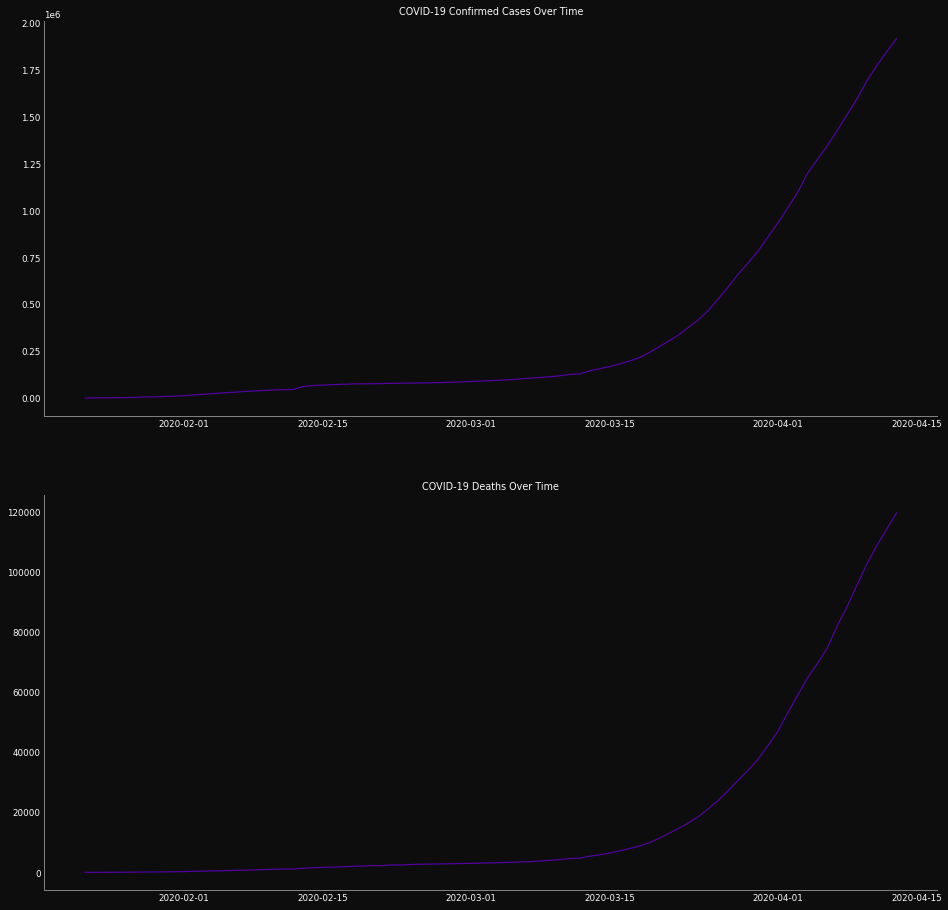

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 16))
ax1.plot(dt, yy)
ax1.set_title("COVID-19 Confirmed Cases Over Time")

ax2.plot(dt_d, yy_d)
ax2.set_title("COVID-19 Deaths Over Time")

The bi-logistic function used for modeling.

In [0]:
def logistic(t, k, delta_t, tm):
    return k / (1 + np.exp(-np.log(81) / delta_t * (t - tm)))

def bi_logistic(t, k1, k2, delta_t, tm1, tm2):
    return logistic(t, k1, delta_t, tm1) + logistic(t, k2, delta_t, tm2)

The class that models the data and predicts given future data. It estimates parameter confidence intervals and has those as well. I'm really suspicious of these confidence intervals, but I can't say for sure there's anything wrong with them *per se*. Alpha is the significance level used for the confidence intervals. As you can see, the confidence intervals are crazy good for the significance level I'm using. I'm really not sure how that's happening, but I guess the algorithm is just very sure of itself.

I've tried using other methods that the `scipy.optimize.curve_fit` function can use, but they all basically agree and give the same results, so we're sticking to the Levenburg-Marquardt algorithm. I'm starting to wish more of the functions I tried to model were logistics! 

The initial conditions aren't as sensitive as I once thought: messing with them a little doesn't really change much, so the current values are probably fine.

In [0]:
class BiLogistic(sklearn.base.BaseEstimator):
    def __init__(self, initial=(1_000_000, 2_000_000, 10, 10, 50), alpha=0.0001):
        self.initial = initial
        self.alpha = alpha
    
    def fit(self, X, y):
        params_, pcov_ = opt.curve_fit(bi_logistic, X, y, self.initial, method='lm', maxfev=20000)
        self.params_ = params_
        self.pcov_ = pcov_

        # credit to http://kitchingroup.cheme.cmu.edu/blog/2013/02/12/Nonlinear-curve-fitting-with-parameter-confidence-intervals/
        # for idea about confidence intervals
    
        ddof = max(0, len(X) - len(params_))
        tval = dist.t.ppf(1 - self.alpha / 2, ddof) 

        self.low_params_ = []
        self.high_params_ = []
        self.errs_ = []
        for p, var in zip(params_, np.diag(pcov_)):
            sigma = np.sqrt(var)
            self.errs_.append(sigma * tval)
            # note: putting all of the low params in one and all of the high params in the other doesn't really make sense
            # but I'm still doing it
            self.low_params_.append(p - sigma * tval)
            self.high_params_.append(p + sigma * tval)
            

    def predict(self, X):
        sklearn.utils.validation.check_is_fitted(self)
        sklearn.utils.validation.check_array(X)

        return np.array([bi_logistic(t, *self.params_) for t in X])

    def predict_low(self, X):
        sklearn.utils.validation.check_is_fitted(self)
        sklearn.utils.validation.check_array(X)

        return np.array([bi_logistic(t, *self.low_params_) for t in X])

    def predict_high(self, X):
        sklearn.utils.validation.check_is_fitted(self)
        sklearn.utils.validation.check_array(X)

        return np.array([bi_logistic(t, *self.high_params_) for t in X])

Modeling all of the data and giving the parameters with the confidence intervals. The sum of $K_1$ and $K_2$ is the theoretical carrying capacity, and I just add the confidence intervals together. That's definitely not good stats, but it's conservative which I like.

In [0]:
print("Cases:")
model = BiLogistic()
model.fit(xx, yy)
for param, val, err in zip(['k1', 'k2', 'Δt', 'tm1', 'tm2'], model.params_, model.errs_):
    print(f"{param} = {val:3} ± {err:.2f}")

print("Projected maximum value: {:.3e} ± {:.3e}".format(
    model.params_[0] + model.params_[1],
    model.errs_[0] + model.errs_[1]))

print("\nDeaths:")
model_d = BiLogistic()
model_d.fit(xx_d, yy_d)
for param, val, err in zip(['k1', 'k2', 'Δt', 'tm1', 'tm2'], model_d.params_, model_d.errs_):
    print(f"{param} = {val:3} ± {err:.2f}")

print("Projected maximum value: {:.3e} ± {:.3e}".format(
    model_d.params_[0] + model_d.params_[1],
    model_d.errs_[0] + model_d.errs_[1]))

Cases:
k1 = 76800.36991134488 ± 10676.90
k2 = 2349224.438777179 ± 111277.68
Δt = 29.304714830033628 ± 1.41
tm1 = 17.177649191598725 ± 4.05
tm2 = 73.74442639285259 ± 0.68
Projected maximum value: 2.426e+06 ± 1.220e+05

Deaths:
k1 = 2405.0369139716504 ± 446.03
k2 = 169556.3617375147 ± 7322.86
Δt = 28.765669574939892 ± 0.98
tm1 = 20.337432102518644 ± 5.14
tm2 = 76.71870686286003 ± 0.58
Projected maximum value: 1.720e+05 ± 7.769e+03


Now we extend the projections into the future. I do draw the CI, but it's basically invisible.

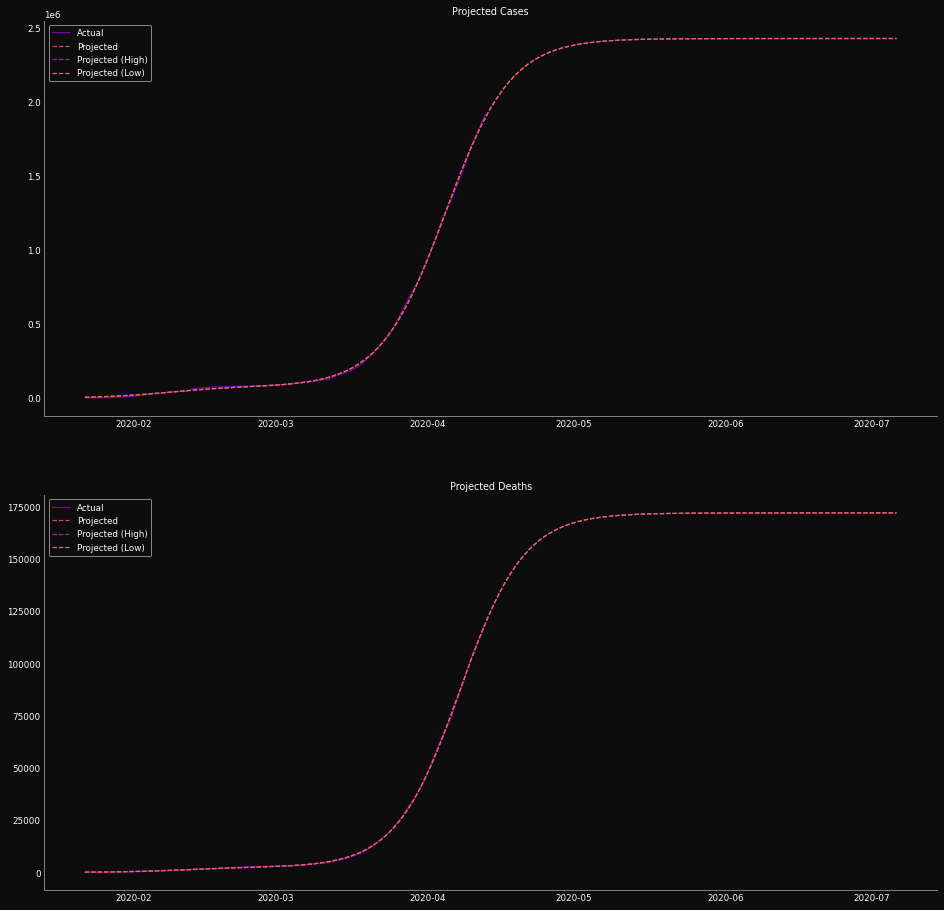

In [0]:
PROJECTION_END = dt[-1] + pd.Timedelta(weeks=12)
extended_dt = pd.date_range(dt[0], PROJECTION_END)
extended_yy = model.predict(np.arange(len(extended_dt)).reshape(-1, 1))

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 16))
ax1.plot(dt, yy, label='Actual', color=colors[1])
ax1.plot(extended_dt, extended_yy, '--', label='Projected', color=colors[3])
ax1.plot(extended_dt, extended_yy, '--', label='Projected (High)', color=colors[2])
ax1.plot(extended_dt, extended_yy, '--', label='Projected (Low)', color=colors[4])
ax1.set_title("Projected Cases")
ax1.legend()

extended_yy_d = model_d.predict(np.arange(len(extended_dt)).reshape(-1, 1))

ax2.plot(dt, yy_d, label='Actual', color=colors[1])
ax2.plot(extended_dt, extended_yy_d, '--', label='Projected', color=colors[3])
ax2.plot(extended_dt, extended_yy_d, '--', label='Projected (High)', color=colors[2])
ax2.plot(extended_dt, extended_yy_d, '--', label='Projected (Low)', color=colors[4])
ax2.set_title("Projected Deaths")
plt.legend()

I think a much better test of the modeling is how well it deals with taking out some data: that way, we can compare its results with known data. I do that here: you put in `n_days` into the function and it removes that many days from the end of the data, fits the model, and then graphs the projection from that date along with the actual data.

In [0]:
def project_with_holdout(n_days=10, ax=plt):
    if n_days != 0:
        training_x, training_y = xx[:-n_days], yy[:-n_days]
    else:
        training_x, training_y = xx, yy
    
    model = BiLogistic()
    model.fit(training_x, training_y)

    PROJECTION_END = dt[-1] + pd.Timedelta(weeks=12)
    extended_dt = pd.date_range(dt[0], PROJECTION_END)
    extended_yy = model.predict(np.arange(len(extended_dt)).reshape(-1, 1))

    title = 'Projection ({} days held from fitting)'.format(n_days)
    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)

    ax.set_ylabel("Cases")
    ax.plot(dt, yy, label='Actual', color=colors[1])
    ax.plot(extended_dt, extended_yy, '--', label='Projected', color=colors[3])
    ax.plot(extended_dt, extended_yy, '--', label='Projected (High)', color=colors[2])
    ax.plot(extended_dt, extended_yy, '--', label='Projected (Low)', color=colors[4])
    ax.legend()

def project_deaths_with_holdout(n_days=10, ax=plt):
    if n_days != 0:
        training_x, training_y = xx_d[:-n_days], yy_d[:-n_days]
    else:
        training_x, training_y = xx_d, yy_d
    
    model = BiLogistic()
    model.fit(training_x, training_y)

    PROJECTION_END = dt_d[-1] + pd.Timedelta(weeks=12)
    extended_dt = pd.date_range(dt_d[0], PROJECTION_END)
    extended_yy = model.predict(np.arange(len(extended_dt)).reshape(-1, 1))

    title = 'Projection ({} days held from fitting)'.format(n_days)
    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)

    ax.set_ylabel("Deaths")  
    ax.plot(dt, yy_d, label='Actual', color=colors[1])
    ax.plot(extended_dt, extended_yy, '--', label='Projected', color=colors[3])
    ax.plot(extended_dt, extended_yy, '--', label='Projected (High)', color=colors[2])
    ax.plot(extended_dt, extended_yy, '--', label='Projected (Low)', color=colors[4])
    ax.legend()

As you can see, the model is always very sure of itself (I swear I'm still drawing CIs, I promise they're on the screen!), but it's extremely optimistic when you hold out some of the recent data. Make of that what you will. Personally, I'm curious how the logistic model compares in this respect to other more widely-used epidemiology models. Change the list of numbers on the second line to change what numbers of days it holds out.

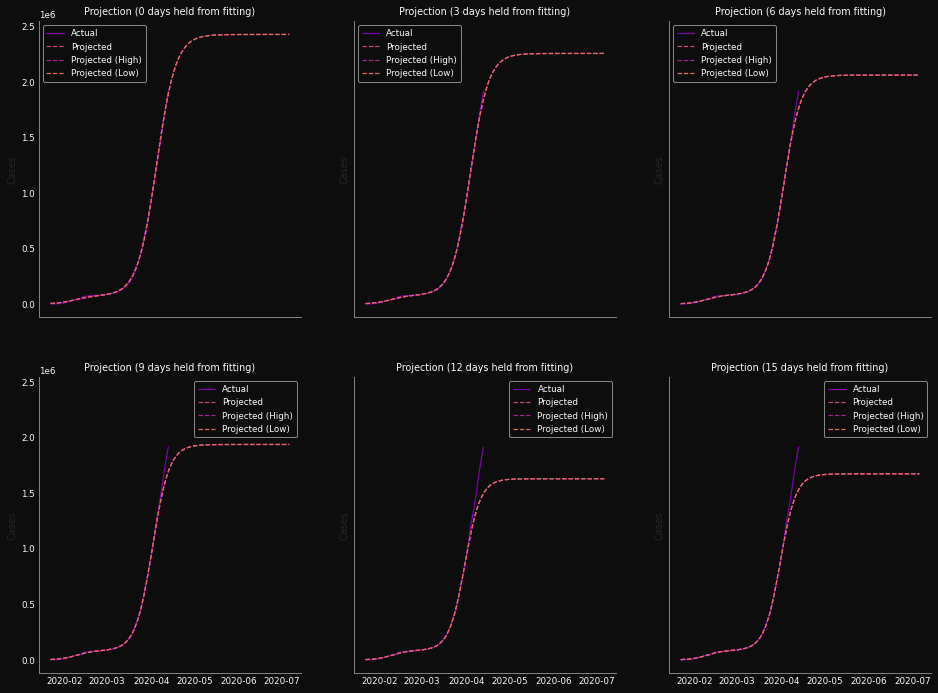

In [0]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 12))
for ax, n in zip(axs.flatten(), (0, 3, 6, 9, 12, 15)):
    project_with_holdout(n, ax)

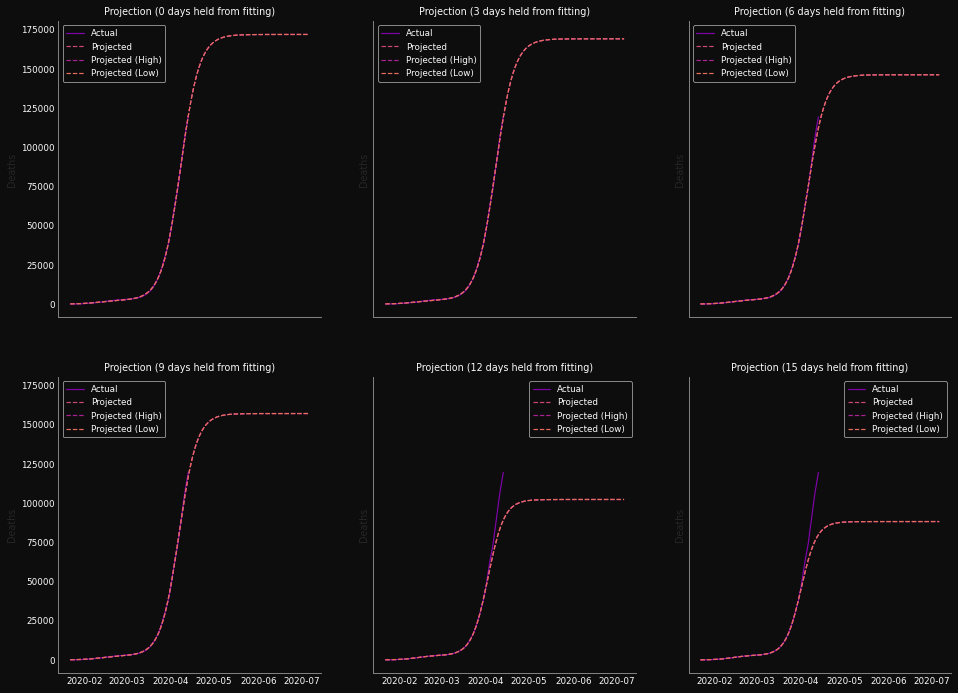

In [0]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 12))
for ax, n in zip(axs.flatten(), (0, 3, 6, 9, 12, 15)):
    project_deaths_with_holdout(n, ax)

Now I tried something different: randomly taking out some days and leaving the rest, instead of taking all of them from the end. This makes models that are very similar to not holding out anything: I think the current data doesn't really have any major outliers, so taking out stuff from the middle doesn't really do anything.

In [0]:
def project_with_random_holdout(n_days=10, ax=plt):
    if n_days != 0:
        inds = np.random.choice(len(xx), len(xx) - n_days)
        training_x, training_y = xx[inds], yy[inds]
    else:
        training_x, training_y = xx, yy
    
    model = BiLogistic()
    model.fit(training_x, training_y)

    PROJECTION_END = dt[-1] + pd.Timedelta(weeks=12)
    extended_dt = pd.date_range(dt[0], PROJECTION_END)
    extended_yy = model.predict(np.arange(len(extended_dt)).reshape(-1, 1))

    title = 'Projection ({} days held from fitting)'.format(n_days)
    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)
    
    ax.set_ylabel("Cases")
    ax.plot(dt, yy, label='Actual', color=colors[1])
    ax.plot(extended_dt, extended_yy, '--', label='Projected', color=colors[3])
    ax.plot(extended_dt, extended_yy, '--', label='Projected (High)', color=colors[2])
    ax.plot(extended_dt, extended_yy, '--', label='Projected (Low)', color=colors[4])
    ax.legend()

def project_deaths_with_random_holdout(n_days=10, ax=plt):
    if n_days != 0:
        inds = np.random.choice(len(xx), len(xx) - n_days)
        training_x, training_y = xx[inds], yy_d[inds]
    else:
        training_x, training_y = xx, yy_d
    
    model = BiLogistic()
    model.fit(training_x, training_y)

    PROJECTION_END = dt[-1] + pd.Timedelta(weeks=12)
    extended_dt = pd.date_range(dt[0], PROJECTION_END)
    extended_yy = model.predict(np.arange(len(extended_dt)).reshape(-1, 1))

    title = 'Projection ({} days held from fitting)'.format(n_days)
    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)
    
    ax.set_ylabel("Deaths")
    ax.plot(dt, yy_d, label='Actual', color=colors[1])
    ax.plot(extended_dt, extended_yy, '--', label='Projected', color=colors[3])
    ax.plot(extended_dt, extended_yy, '--', label='Projected (High)', color=colors[2])
    ax.plot(extended_dt, extended_yy, '--', label='Projected (Low)', color=colors[4])
    ax.legend()

As you can see, even when holding out more days than last time, the projections are extraordinarily similar.

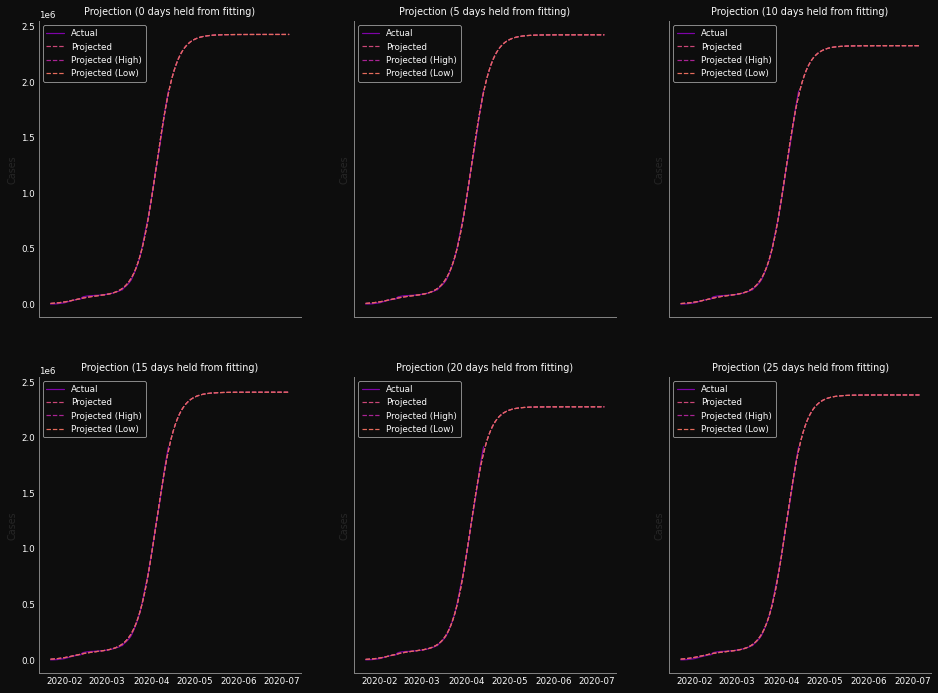

In [0]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 12))
for ax, n in zip(axs.flatten(), (0, 5, 10, 15, 20, 25)):
    project_with_random_holdout(n, ax)

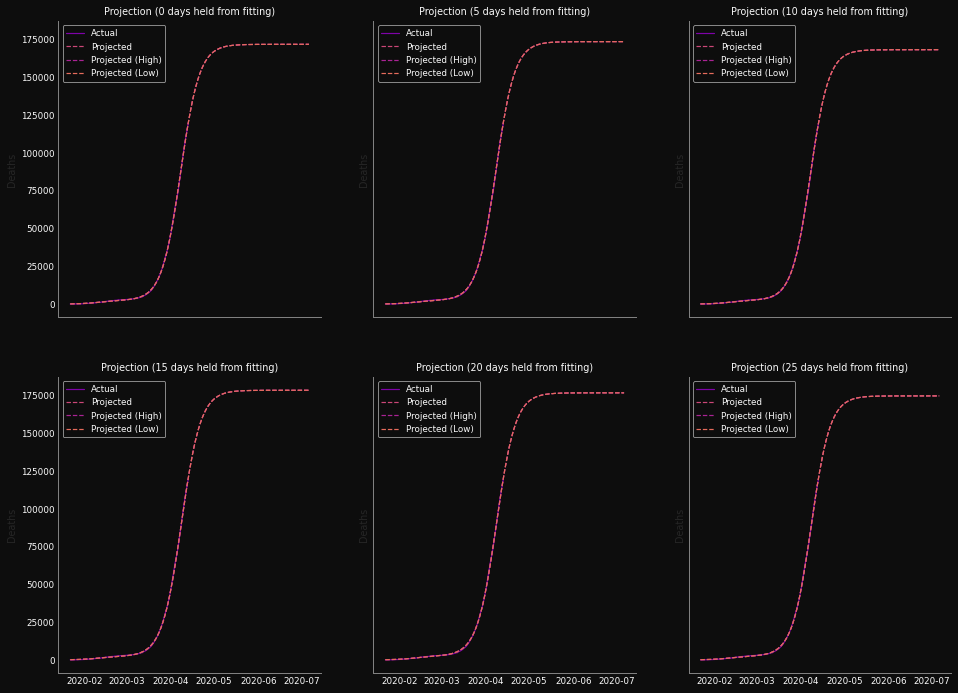

In [0]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 12))
for ax, n in zip(axs.flatten(), (0, 5, 10, 15, 20, 25)):
    project_deaths_with_random_holdout(n, ax)

One way of trying to estimate a CI would be by assuming that the data itself has some sort of normally-distributed error and modeling that. This is what the below function does: it takes in a standard deviation (so `sd=0.1` would make each data point, on average, vary by 10% of its original value), a number of datasets to use, and then plots all of the models. This gives results that I think look far more "right". 

Every so often, with higher variations and more datasets, it'll get a dataset that's bad enough it can't fit it and just quits. Just rerun it or decrease the sigma to prevent that from happening.

This provides a very rudimentary way of doing 95% CIs: just do 40 datasets and take out the bottom and top ones! I allow you to take out `n` models on either side in the last argument, which defaults to taking out 1. The printed graphs below are with 40 runs, so it'll show a 95% CI of sorts.

What's the actual error in the data? I have no idea. Is 7% reasonable? I hope so.

In [0]:
def project_with_jiggle(sd=0.1, num_datasets=40, ax=plt, take_out_extrema=1):
    yys = []
    for _ in range(num_datasets):
        training_x, training_y = xx, yy * (1 + sd * np.random.randn(len(yy)))
        model = BiLogistic()
        model.fit(training_x, training_y)

        PROJECTION_END = dt[-1] + pd.Timedelta(weeks=12)
        extended_dt = pd.date_range(dt[0], PROJECTION_END)
        extended_yy = model.predict(np.arange(len(extended_dt)).reshape(-1, 1))
        yys.append(extended_yy)

    yys.sort(key=lambda x: x[-1])
    yys = yys[take_out_extrema:-take_out_extrema]

    title = "Projections (random variation σ={} added to each model's training data)".format(sd)
    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)
    
    ax.set_ylabel("Cases")
    ax.plot(dt, yy, label='Actual', color=colors[1])
    for extended_yy in yys:
        ax.plot(extended_dt, extended_yy, '--', label='Projected', color=colors[3])

def project_deaths_with_jiggle(sd=0.1, num_datasets=40, ax=plt, take_out_extrema=1):
    yys = []
    for _ in range(num_datasets):
        training_x, training_y = xx, yy_d * (1 + sd * np.random.randn(len(yy)))
        model = BiLogistic()
        model.fit(training_x, training_y)

        PROJECTION_END = dt[-1] + pd.Timedelta(weeks=12)
        extended_dt = pd.date_range(dt[0], PROJECTION_END)
        extended_yy = model.predict(np.arange(len(extended_dt)).reshape(-1, 1))
        yys.append(extended_yy)

    yys.sort(key=lambda x: x[-1])
    yys = yys[take_out_extrema:-take_out_extrema]

    title = "Projections (random variation σ={} added to each model's training data)".format(sd)
    if ax == plt:
        plt.title(title)
    else:
        ax.set_title(title)
    
    ax.set_ylabel("Deaths")
    ax.plot(dt, yy_d, label='Actual', color=colors[1])
    for extended_yy in yys:
        ax.plot(extended_dt, extended_yy, '--', label='Projected', color=colors[3])

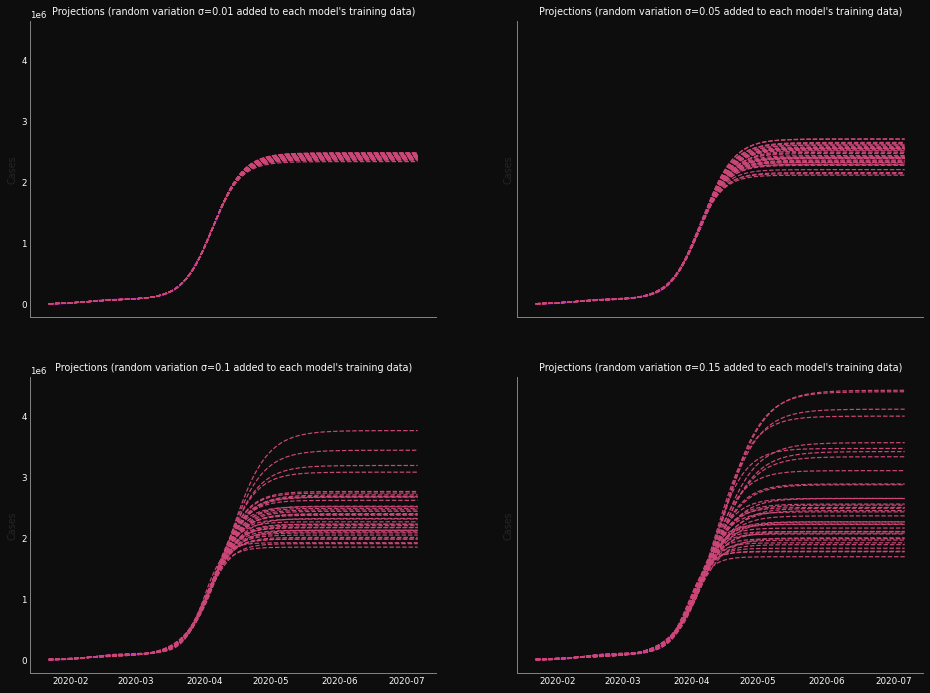

In [0]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
for ax, sd in zip(axs.flatten(), (0.01, 0.05, 0.1, 0.15)):
    project_with_jiggle(sd, 40, ax, 1)

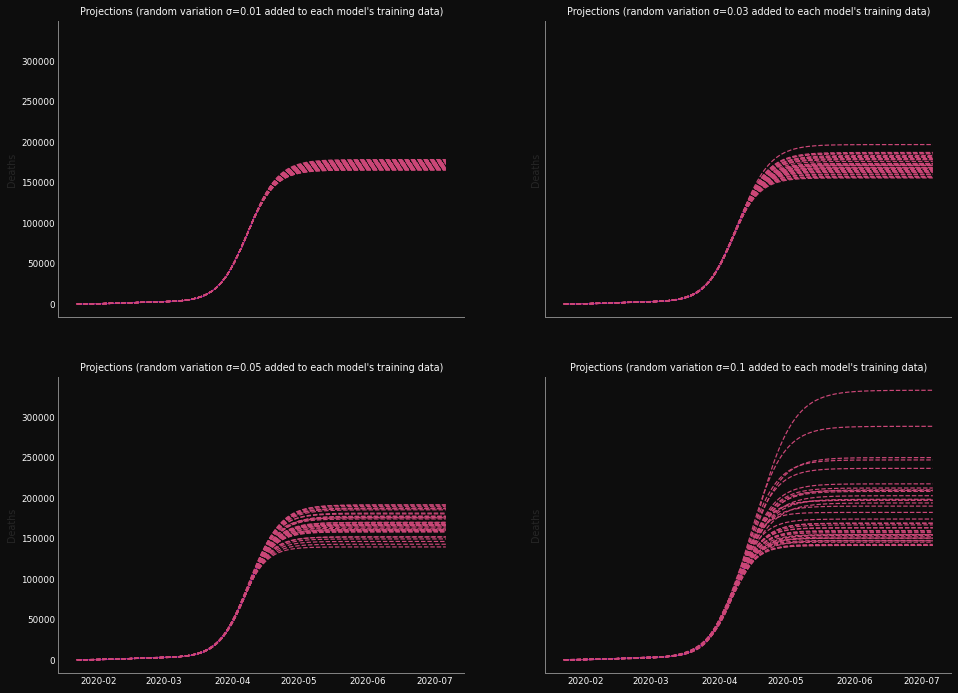

In [0]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(16, 12))
for ax, sd in zip(axs.flatten(), (0.01, 0.03, 0.05, 0.1)):
    project_deaths_with_jiggle(sd, 40, ax, 1)